### 1. Importing Data

In [1]:
#importing all the important libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime

In [2]:
#applying transformation to input image along with defining batch size
transform = transforms.Compose([
        transforms.Resize((32,32)),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))
]) 
Batch_Size = 128

In [3]:
#loading the training and testing MNIST data set
train_data = datasets.MNIST(root='./data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='./data',train=False,download=True,transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Batch_Size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Batch_Size,shuffle=True)


### 2. View data - class


In [4]:
#printing output class of data
classes=train_data.classes
print(classes)
print(train_data.class_to_idx)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


### 3. View pictures


In [5]:
#defining a function to show images
def show_data(img):
    #as we have transformed image using normalisation so it will detransform it
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


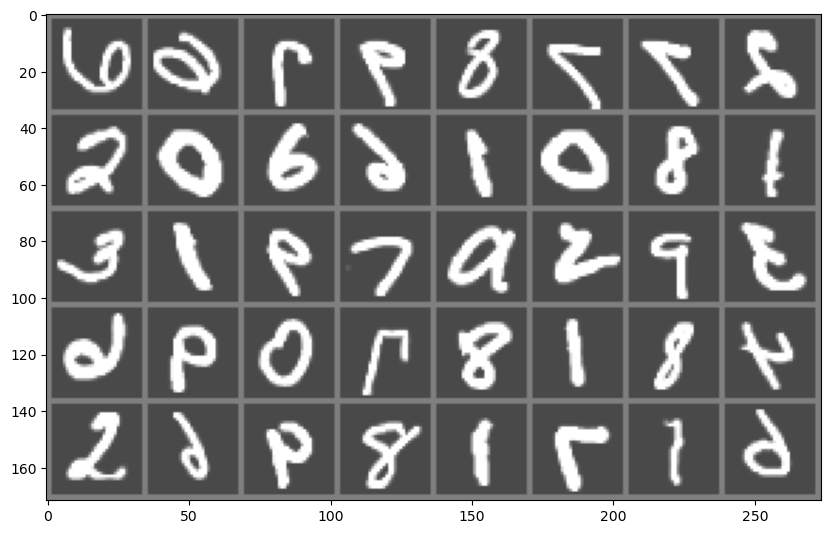

In [6]:
#showing total 40 pictures in grid
im,label = next(iter(train_dataloader))
plt.figure(figsize=(10,12))
show_data(torchvision.utils.make_grid(im[:40]))


### 4. Definition Network (VGG)


In [7]:
#setting the device to cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
#VGG configuration for all its structure
vgg_config = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

### 5.Original VGG-19 model

In [9]:
#This is modified VGG code
class VGG_orig(nn.Module):
    
    def __init__(self, vgg_name):
        super(VGG_orig, self).__init__()
        #initializing the convolutional layer as per required VGG configuration
        self.features = self.vgg_layers(vgg_config[vgg_name])
        #defining the classifier of the network
        self.classifier = nn.Sequential(
            #First fully connected layer
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            #second fully connected layer
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            #third fully connected layer
            nn.Linear(512,10),
        )
        #initializing weights
        self.init_weight()
        
    def forward(self, x):
        #defining forward pass
        out = self.features(x)
        out = out.view(out.size(0), -1)
        #passing the flattened output through classifier
        out = self.classifier(out)
        return out
    
    def vgg_layers(self, vgg_config):
        #as MNIST has 1 channel
        input_channel = 1
        #setting up the layers for feature extractor
        layers = []
        for x in vgg_config:
            #Adding a max pooling layer
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            #Adding a convolutional layer without batch normalisation
            else:
                layers += [nn.Conv2d(input_channel, x, kernel_size=3, padding=1),nn.ReLU(inplace=True)]
                input_channel = x 
        return nn.Sequential(*layers)
    
    def init_weight(self):
        #initializing weights for all modules
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #initializing weight with xavier function
                nn.init.normal_(m.weight.data,mean=0, std=0.01)
                if m.bias is not None:
                    #initializing biases as zero
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                 # Initialize fully-connected layers with normal distribution
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


### 6. Modified VGG-19 model

In [10]:
#This is modified VGG code
class VGG_modify(nn.Module):
    
    def __init__(self, vgg_name):
        super(VGG_modify, self).__init__()
        #initializing the convolutional layer as per required VGG configuration
        self.features = self.vgg_layers(vgg_config[vgg_name])
        #defining the classifier of the network
        self.classifier = nn.Sequential(
            #First fully connected layer
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            #second fully connected layer
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            #third fully connected layer
            nn.Linear(512,10),
        )
        #initializing weights
        self.init_weight()
        
    def forward(self, x):
        #defining forward pass
        out = self.features(x)
        out = out.view(out.size(0), -1)
        #passing the flattened output through classifier
        out = self.classifier(out)
        return out
    
    def vgg_layers(self, vgg_config):
        #as MNIST has 1 channel
        input_channel = 1
        #setting up the layers for feature extractor
        layers = []
        for x in vgg_config:
            #Adding a max pooling layer
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            #Adding a convolutional layer with batch normalisation
            else:
                layers += [nn.Conv2d(input_channel, x, kernel_size=3, padding=1),nn.BatchNorm2d(x),nn.ReLU(inplace=True)]
                input_channel = x 
        return nn.Sequential(*layers)
    
    def init_weight(self):
        #initializing weights for all modules
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #initializing weight with xavier function
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    #initializing biases as zero
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                # Initialize batch normalization weights and biases
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                 # Initialize fully-connected layers with normal distribution
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()



### 7. Define the loss function and optimizer


In [11]:
#Defining the VGG-19 of original model
net = VGG_orig('VGG19').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark=True

#Defining the VGG-19 of modified model
net_modify = VGG_modify('VGG19').to(device)
if device == 'cuda':
    net_modify = nn.DataParallel(net_modify)
    torch.backends.cudnn.benchmark=True

In [12]:
#optimizer for original VGG-19 net
optimizer_sgd= optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd, 'min', factor=0.5,patience = 5,min_lr = 0.000001) 

#optimizer for modified VGG-19 net
optimizer_sgd_modify= optim.SGD(net_modify.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler_sgd_modify = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_modify, 'min', factor=0.5,patience = 5,min_lr = 0.000001) 

criterion = nn.CrossEntropyLoss()




### 8. Training


In [13]:
#creating the path to save the model
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/VGG19.pth'

The file already exists


In [14]:
# function for model training and recording its loss and accuracy
def train(model, trainloader, optimizer, criterion,scheduler):
    #training the model
    model.train()
    #initializing the loss and accuracy as 0
    training_loss = 0.0
    training_acc = 0
    count = 0
    #iterating through the training data
    for i, data in enumerate(trainloader):
        total=len(trainloader)
        count += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        #clearing previous gradient
        optimizer.zero_grad()
        #clearing cuda cache to free memory
        if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        # forward pass
        outputs = model(image)
        # calculating the loss
        loss = criterion(outputs, labels)
        #backward pass
        loss.backward()
        #optimization setp to update parameter
        optimizer.step()

        #calculating the loss
        training_loss += loss.item()
        # calculating the accuracy
        _, preds = torch.max(outputs.data, 1)
        training_acc += (preds == labels).sum().item()

        #printing the progress of training per epoch
        rate = (i + 1) / total
        a = "*" * int(rate * 50)
        b = "." * (50 - int(rate * 50))
        print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')

    #claculating the loss and accuracy over all batches
    epoch_loss = training_loss / count
    epoch_acc = 100. * (training_acc / len(trainloader.dataset))
    #stepping the scheduler based on loss per epoch
    scheduler.step(epoch_loss)
    
    # Logging the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    return epoch_loss, epoch_acc,current_lr

In [15]:
#this is the code for model validation
def validate(model, testloader, criterion):
    #setting the model on validating mode
    model.eval()
    #making a list to calculate accuracy for each model
    accurate_class = list(0. for i in range(10))
    total_class = list(0. for i in range(10))

    #initializing validation loss and accuracy
    validation_loss = 0.0
    validation_accuracy = 0
    count = 0

    #disabling gradient computation for validation
    with torch.no_grad():
        for i, data in enumerate(testloader):
            total=len(testloader)
            count += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
            # forward pass
            outputs = model(image)
            # calculating the loss
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            # calculating  the accuracy
            _, preds = torch.max(outputs.data, 1)
            validation_accuracy += (preds == labels).sum().item()
            # calculating the accuracy for each class
            correct  = (preds == labels).squeeze()

            #printing per epoch to track
            rate = (i + 1) / total
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r test {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')
            
            for i in range(len(preds)):
                label = labels[i]
                accurate_class[label] += correct[i].item()
                total_class[label] += 1
    epoch_loss = validation_loss / count
    epoch_acc = 100. * (validation_accuracy / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [16]:
#This is for training and validating the model calling required functions per epochs
def train_validate(model,optimizer,scheduler):
    #initializing empty list for loss and accuracy
    training_loss, validation_loss = [], []
    training_acc, validation_acc = [], []
    #calculating the total time
    time_taken = time.time()
    for epoch in range(epochs):
        print(f"[INFO][{datetime.datetime.now()}]: Epoch {epoch+1} of {epochs}")
        #calculating the time per epoch 
        start_time=time.time()

        #training the model
        train_epoch_loss, train_epoch_acc,lr = train(model, train_dataloader, optimizer, criterion,scheduler)
        #validating the model
        valid_epoch_loss, valid_epoch_acc = validate(model, test_dataloader,  criterion)
        #updating the loss and accuracy list
        training_loss.append(train_epoch_loss)
        validation_loss.append(valid_epoch_loss)
        training_acc.append(train_epoch_acc)
        validation_acc.append(valid_epoch_acc)
        #calculating the end time per epoch
        total_time=time.time()-start_time
        #printing details per epoch
        total_time= time.strftime('%H:%M:%S', time.gmtime(total_time))
        print(f"\rTraining loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}, Learning rate: {lr} Time: {total_time}")

        print('-'*50)
        
    total_time_taken= time.strftime('%H:%M:%S', time.gmtime(time.time()-time_taken))
    print(f"\nFinal time taken to run total is::{total_time_taken}")
    return training_loss, validation_loss, training_acc, validation_acc

In [17]:
def plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Plot accuracy in the first subplot
    ax1.plot(training_acc, color='green', linestyle='-', label='train accuracy')
    ax1.plot(validation_acc, color='blue', linestyle='-', label='validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.set_title('Accuracy Over Epochs')

    # Plot loss in the second subplot
    ax2.plot(training_loss, color='orange', linestyle='-', label='train loss')
    ax2.plot(validation_loss, color='red', linestyle='-', label='validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.set_title('Loss Over Epochs')

    # Show the plots
    plt.tight_layout()
    plt.show()
    print(f"\nTraining loss::{training_loss}")
    print(f"\nValidation loss::{validation_loss}")
    print(f"\nTraining Accuracy::{training_acc}")
    print(f"\nValidation Accuracy::{validation_acc}")

In [18]:
def test_model(model):
    correct = 0
    total = 0
    class_correct = list(0.for i in range(10))
    class_total = list(0.for i in range(10))
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images) 
    
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [19]:
#this is for printing the correct and predicted label of model
def print_image(model):
    # Getting one batch of test images and labels
    dataiter = iter(test_dataloader)
    images, labels = next(dataiter)
    images_ = images
    images_ = images_.to(device)
    labels = labels.to(device)
    # Computing the model's output (predictions)
    val_output = model(images_)
    _, val_preds = torch.max(val_output, 1)

    fig = plt.figure(figsize=(25,4))

    # Calculating and print the accuracy for this batch
    correct = torch.sum(val_preds == labels.data).item()

    val_preds = val_preds.cpu()
    labels = labels.cpu()
    
    print("Accuracy Rate per batch = {}%".format(correct/len(images) * 100))

    #displaying predicted and corrected label
    fig = plt.figure(figsize=(25,25))
    for idx in np.arange(32):    
        ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
        show_data(images[idx])
        ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

    #printing the confusion matrix for this batch
    conf_matrix = confusion_matrix(labels, val_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## 9. Implementing original model

[INFO][2024-05-09 20:01:26.497047]: Epoch 1 of 10


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training loss: 2.302, training acc: 11.163, Validation loss: 2.302, validation acc: 11.350, Learning rate: 0.001 Time: 00:00:36
--------------------------------------------------
[INFO][2024-05-09 20:02:03.201070]: Epoch 2 of 10
Training loss: 2.302, training acc: 11.237, Validation loss: 2.301, validation acc: 11.350, Learning rate: 0.001 Time: 00:00:35
--------------------------------------------------
[INFO][2024-05-09 20:02:38.524236]: Epoch 3 of 10
Training loss: 2.301, training acc: 11.237, Validation loss: 2.301, validation acc: 11.350, Learning rate: 0.001 Time: 00:00:35
--------------------------------------------------
[INFO][2024-05-09 20:03:14.178546]: Epoch 4 of 10
Training loss: 2.301, training acc: 11.237, Validation loss: 2.301, validation acc: 11.350, Learning rate: 0.001 Time: 00:00:34
--------------------------------------------------
[INFO][2024-05-09 20:03:48.278995]: Epoch 5 of 10
Training loss: 2.301, training acc: 11.237, Validation loss: 2.301, validation acc: 

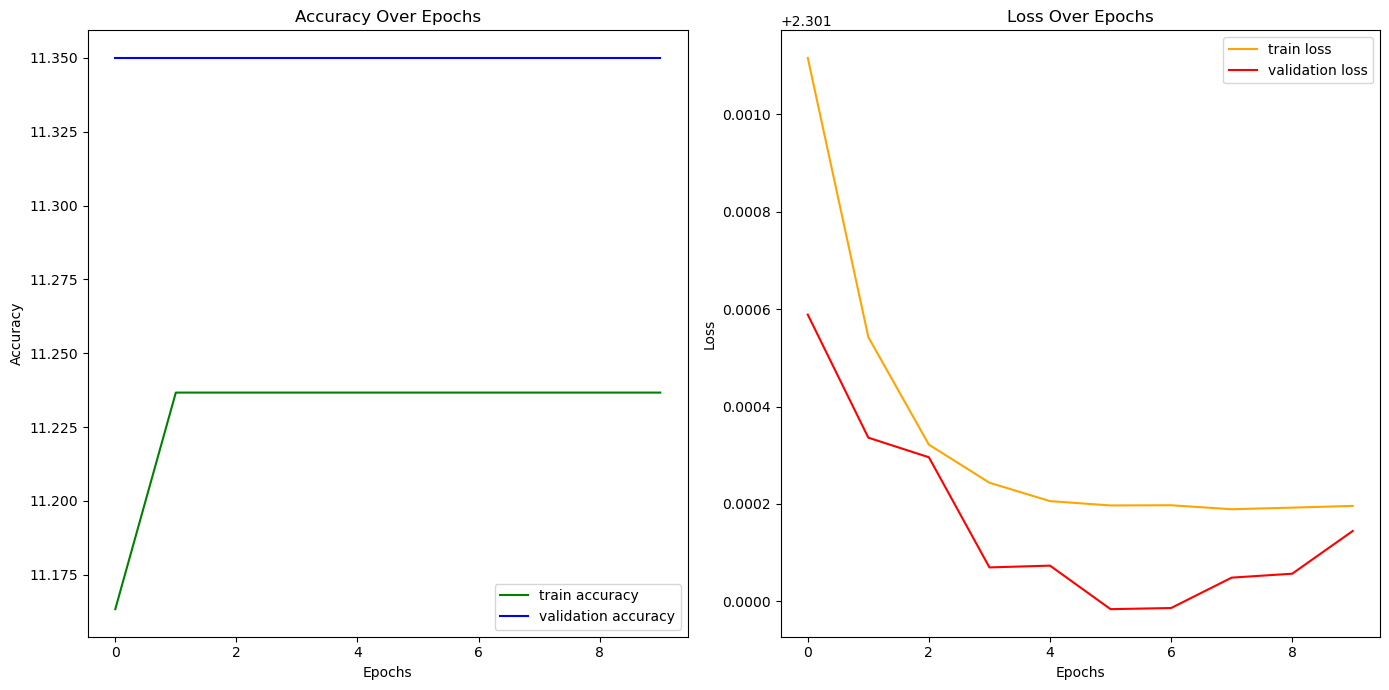


Training loss::[2.3021157697828087, 2.3015425642416165, 2.3013217164509334, 2.3012435507418503, 2.3012058038447205, 2.3011968944118477, 2.3011973158382912, 2.3011891201360903, 2.3011924117358764, 2.3011959702221314]

Validation loss::[2.301588665080976, 2.3013360017462623, 2.301295829724662, 2.3010696791395358, 2.3010733550107934, 2.3009839812411537, 2.300986320157594, 2.3010487103764015, 2.301056786428524, 2.3011445063578932]

Training Accuracy::[11.163333333333334, 11.236666666666666, 11.236666666666666, 11.236666666666666, 11.236666666666666, 11.236666666666666, 11.236666666666666, 11.236666666666666, 11.236666666666666, 11.236666666666666]

Validation Accuracy::[11.35, 11.35, 11.35, 11.35, 11.35, 11.35, 11.35, 11.35, 11.35, 11.35]
Accuracy of the network on the 10000 test images: 11.35 %
Accuracy of 0 - zero : 0.00 %
Accuracy of 1 - one : 100.00 %
Accuracy of 2 - two : 0.00 %
Accuracy of 3 - three : 0.00 %
Accuracy of 4 - four : 0.00 %
Accuracy of 5 - five : 0.00 %
Accuracy of 6 -

<Figure size 2500x400 with 0 Axes>

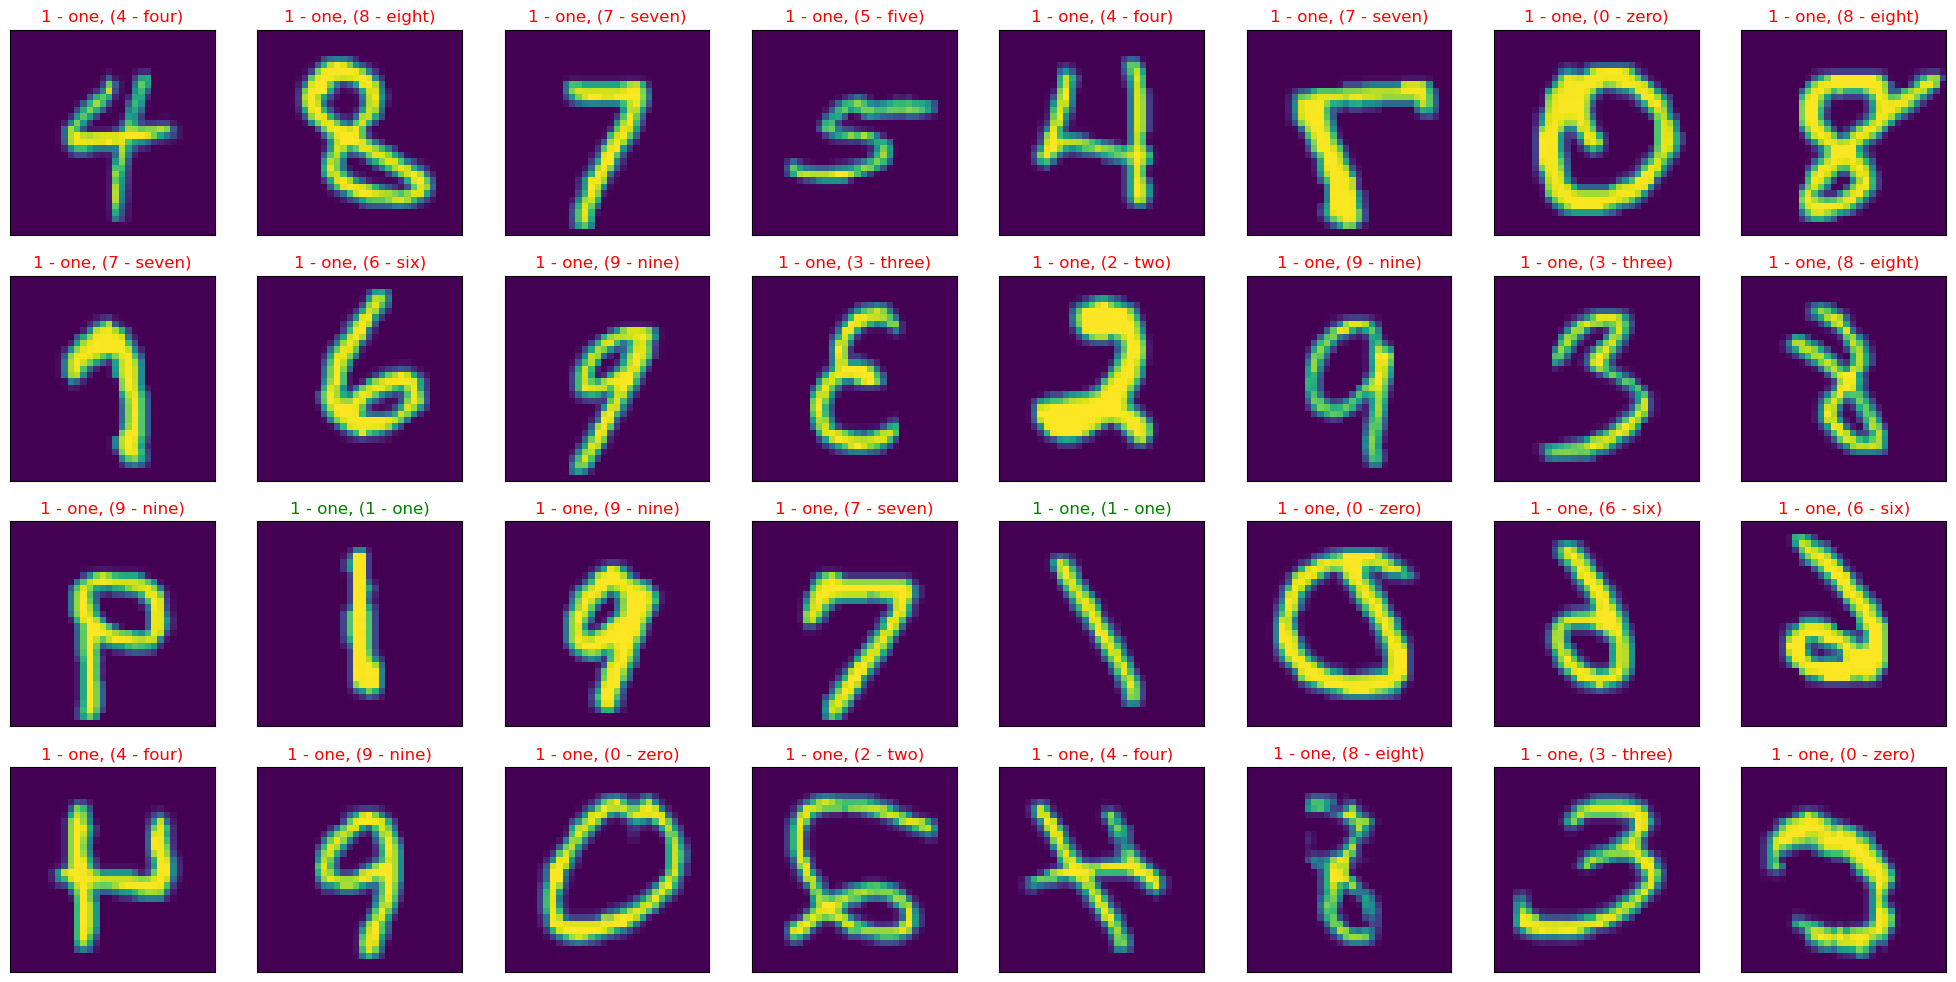

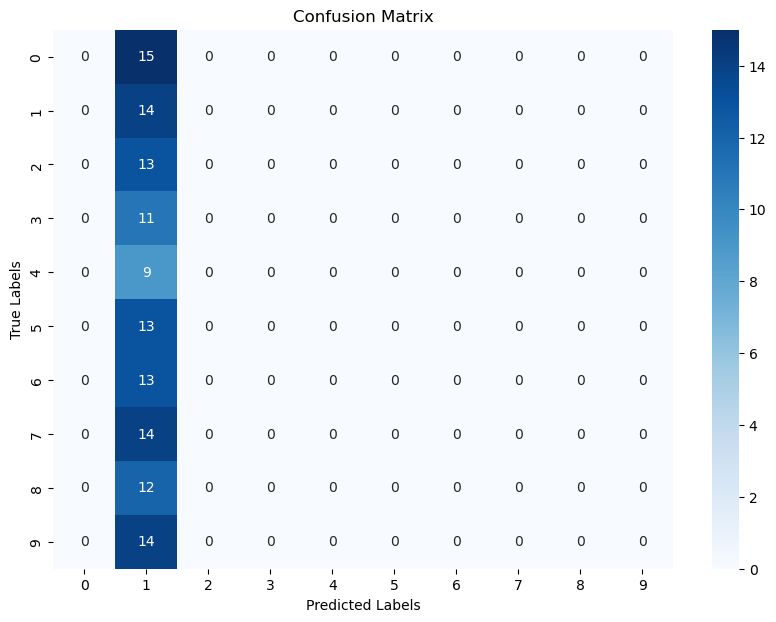

In [20]:
epochs=10
training_loss, validation_loss, training_acc, validation_acc= train_validate(net,optimizer_sgd,scheduler_sgd)
plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc)
test_model(net)
print_image(net)

## 10. Implemeting modified model

[INFO][2024-05-09 20:11:06.508986]: Epoch 1 of 20
Training loss: 2.243, training acc: 18.493, Validation loss: 1.851, validation acc: 21.060, Learning rate: 0.001 Time: 00:00:39
--------------------------------------------------
[INFO][2024-05-09 20:11:46.428909]: Epoch 2 of 20
Training loss: 1.356, training acc: 43.890, Validation loss: 0.669, validation acc: 79.780, Learning rate: 0.001 Time: 00:00:39
--------------------------------------------------
[INFO][2024-05-09 20:12:25.679045]: Epoch 3 of 20
Training loss: 0.335, training acc: 90.310, Validation loss: 0.164, validation acc: 95.100, Learning rate: 0.001 Time: 00:00:40
--------------------------------------------------
[INFO][2024-05-09 20:13:05.750312]: Epoch 4 of 20
Training loss: 0.123, training acc: 96.902, Validation loss: 0.124, validation acc: 96.110, Learning rate: 0.001 Time: 00:00:39
--------------------------------------------------
[INFO][2024-05-09 20:13:45.080216]: Epoch 5 of 20
Training loss: 0.075, training acc

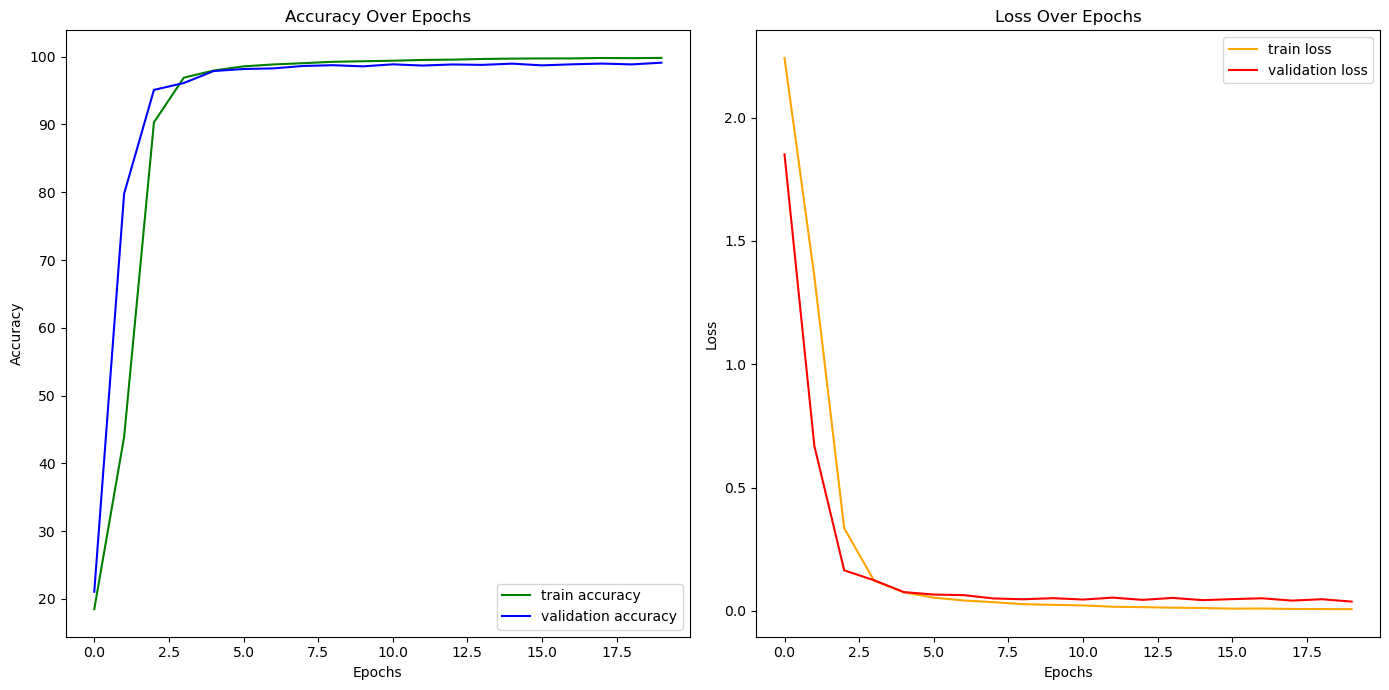


Training loss::[2.242588421937499, 1.3564431383919868, 0.33490323232435215, 0.12282561422633465, 0.07509525271573428, 0.05360390621422133, 0.04212245038513944, 0.0353034000971845, 0.027100602282024523, 0.024311588680955457, 0.022051400131434758, 0.01677462020725099, 0.015005601822698453, 0.012820149566466882, 0.011513610757060293, 0.008977329560882175, 0.009514426338677006, 0.007724029281839871, 0.00737253839940901, 0.006891660087283697]

Validation loss::[1.8513778614092478, 0.6690770199027243, 0.16430941261822665, 0.12411073368938663, 0.07603036381209953, 0.06609266118111112, 0.0637833867634682, 0.05041093775955371, 0.04692879353084047, 0.051507022150768605, 0.04579801944856638, 0.05365299468099646, 0.04453131421822819, 0.05258102794885164, 0.04349725325282404, 0.04763022990738148, 0.05093252248654976, 0.04157974064067195, 0.04720430753523148, 0.03762935426880464]

Training Accuracy::[18.493333333333332, 43.89, 90.31, 96.90166666666667, 97.95166666666667, 98.57000000000001, 98.85166

<Figure size 2500x400 with 0 Axes>

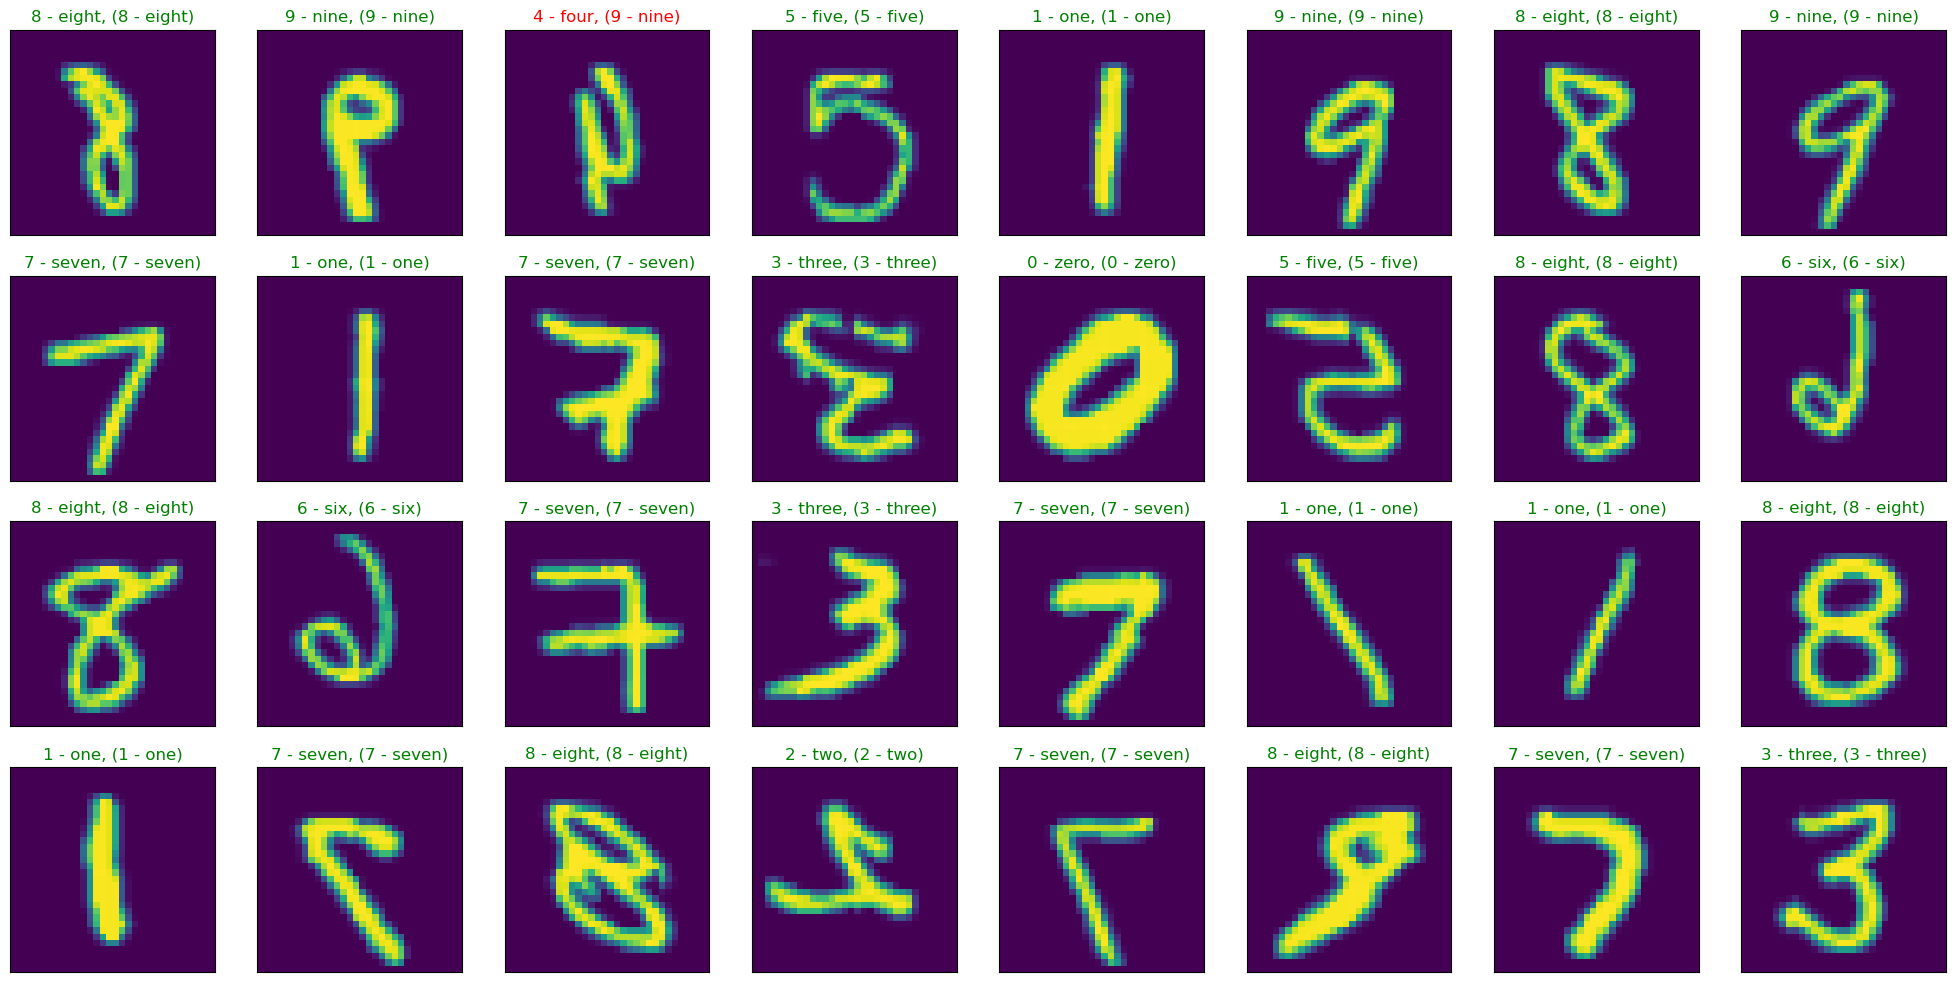

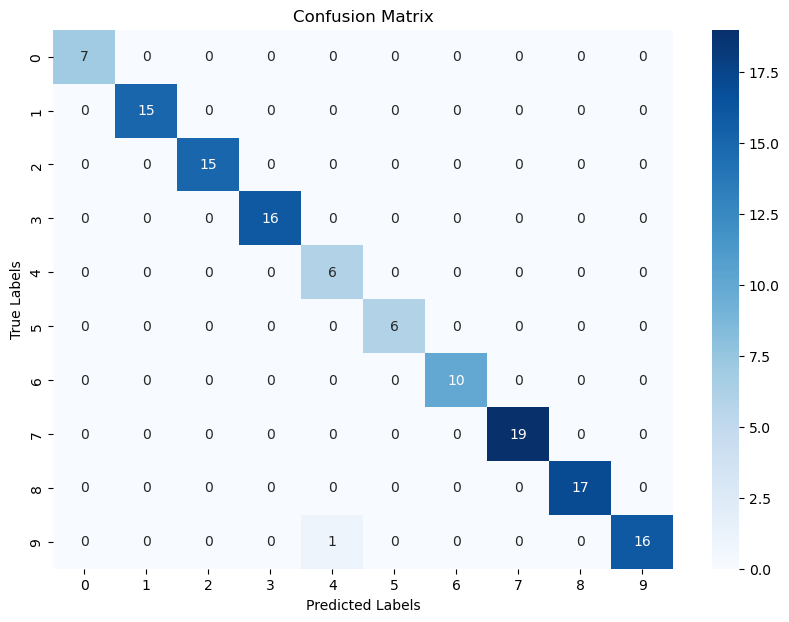

In [21]:
epochs = 20
training_loss, validation_loss, training_acc, validation_acc=train_validate(net_modify,optimizer_sgd_modify,scheduler_sgd_modify)
print("\n")
plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc)
print("\n")
test_model(net_modify)
print("\n")
print_image(net_modify)


## 11. Save the model


In [22]:
torch.save(net_modify,save_path[:-4]+str(epochs+1)+'.pth')